In [1]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import os
import sys
import pandas as pd
import pickle
import numpy as np

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from batch_sv_system_utils import get_embeds, cosine_sim, compute_error, compute_eer
from batch_sv_system_utils import run_trial, plot_score 

In [3]:
# for kaldi_io
os.environ['KALDI_ROOT'] = "/dataset/muncok/kaldi/"

In [4]:
from utils import key2df, df2dict
keys = pickle.load(open("xvector_tdnn7_embeds/sv_keys.pkl", "rb"))
key_df = key2df(keys)
id2idx, idx2id = df2dict(key_df) 

In [14]:
# thresholds
vT = 10
eT = 20

In [39]:
import kaldi_io
import itertools
import subprocess
from batch_sv_system_utils import compute_eer

def compute_plda_score(enr_embeds, test_embeds, test_labels, plda_dir, score_dir="./plda_score"):
    enr_keys = ['enr{}'.format(i) for i in range(len(enr_embeds))]
    test_keys = ['test_{}'.format(i) for i in range(len(test_embeds))]
    keys = enr_keys + test_keys
    embeds = np.concatenate([enr_embeds, test_embeds])

    if not os.path.isdir(score_dir):
        os.makedirs(score_dir)
    ark_scp_output='ark:| copy-vector ark:- ark,scp:{output}/feats.ark,{output}/feats.scp'.format(output=score_dir)
    with kaldi_io.open_or_fd(ark_scp_output, "wb") as f:
        for key, vec in zip(keys, embeds):
            kaldi_io.write_vec_flt(f, vec.squeeze(), key=str(key))

    with open("{}/kaldi_trial".format(score_dir), "w") as f:
        trial_pairs = itertools.product(enr_keys, test_keys)
        for pair in trial_pairs:
            f.write(" ".join(pair))
            f.write("\n")

    subprocess.call("./plda_score.sh {} {}".format(plda_dir, score_dir), shell=True)
    
    plda_scores = pd.read_csv("{}/plda_scores".format(score_dir), delimiter=" ", names=["enroll", "test", "score"]).score
    plda_scores = np.array(plda_scores)
    plda_scores = plda_scores.reshape(len(enr_keys), -1)
    assert plda_scores.shape[1] == len(test_embeds)
    
    plda_score_fusion = plda_scores.mean(0)
    pos_scores = plda_score_fusion[test_labels == 1]
    neg_scores = plda_score_fusion[test_labels == 0]
    compute_eer(pos_scores, neg_scores)
    
    return plda_scores 

## PLDA Score

In [7]:
plda_model_dir = "xvector_tdnn7_embeds/plda_train/"

### sv_embeds 

In [8]:
# full frames
sv_embeds = np.load("xvector_tdnn7_embeds/sv_embeds.npy")
# 300 frames
sv_embeds_300f = np.load("embeddings/voxc2_fbank64_voxc2untied_tdnn7_300f_embeds/sv_embeds.npy")
# 100 frames
sv_embeds_100f = np.load("embeddings/voxc2_fbank64_voxc2untied_tdnn7_100f_embeds/sv_embeds.npy")

### Trials

minDCF: 0.1556, thesh:19.6543


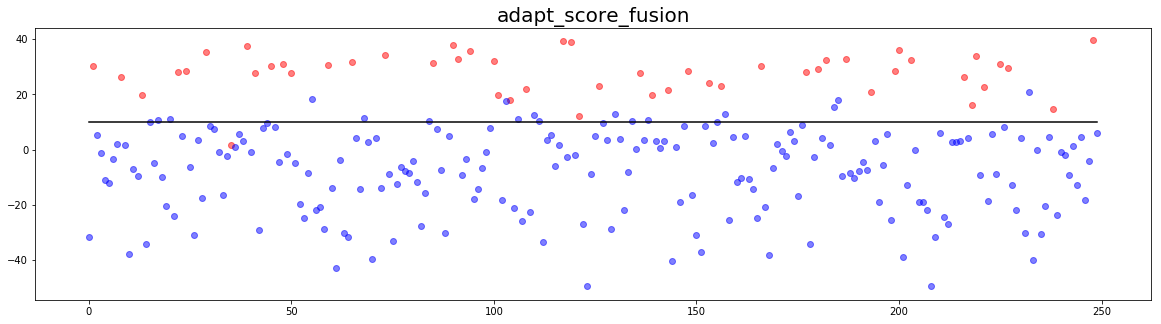

minDCF: 0.1511, thesh:17.1118


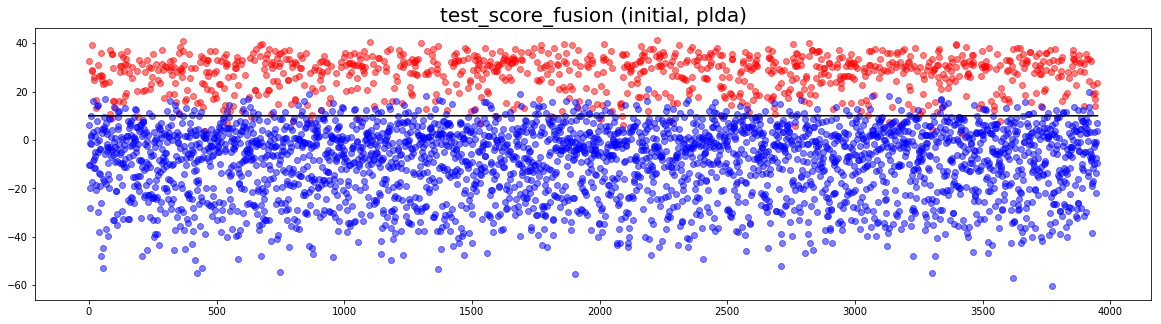

minDCF: 0.0358, thesh:19.0978


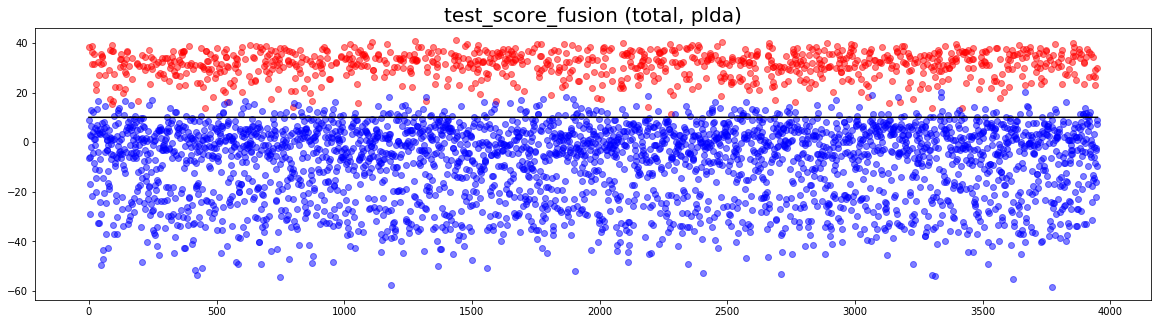

In [47]:
trial = pickle.load(open("trials/enr306/short_enr_test/trials.pkl", "rb"))
# trial = pickle.load(open("trials/enr306/enr306_closedset_big/FS_5//trials.pkl", "rb"))
# trial_info = pickle.load(open("trials/enr306/enr306_closedset_big/FS_5/trial_info.pkl", "rb"))
# sort trials by enr_spk
trial = sorted(trial, key=lambda x: x[0])
t_idx = 30
# enr_spk, enr_ids, test_trial, adapt_trial, ood_trial = trial[t_idx]
enr_spk, enr_ids, adapt_trial, test_trial = trial[t_idx]

enr_embeds = get_embeds(enr_ids, sv_embeds, id2idx)
adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, id2idx)
test_embeds = get_embeds(test_trial[0], sv_embeds, id2idx)

adapt_score_fusion = compute_plda_score(enr_embeds, adapt_embeds, adapt_trial[1], plda_model_dir).mean(0)
adapt_enr_idx = np.nonzero(adapt_score_fusion > eT)
adapt_enr_ids = np.array(adapt_trial[0])[adapt_enr_idx]
total_enr_ids = np.concatenate([enr_ids, adapt_enr_ids])
total_enr_embeds = get_embeds(total_enr_ids, sv_embeds, id2idx)

plot_score(adapt_score_fusion, adapt_trial[1], vT, "adapt_score_fusion")

init_test_scores = compute_plda_score(enr_embeds, test_embeds, test_trial[1], plda_model_dir)
plot_score(init_test_scores.mean(0), test_trial[1], vT, "test_score_fusion (initial, plda)")

total_test_scores = compute_plda_score(total_enr_embeds, test_embeds, test_trial[1], plda_model_dir)
plot_score(total_test_scores.mean(0), test_trial[1], vT, "test_score_fusion (total, plda)")


### Iterate trials

In [96]:
for tr in trial:
    enr_spk, enr_ids, adapt_trial, test_trial = tr
    enr_embeds = get_embeds(enr_ids, sv_embeds_full, id2idx)
    adapt_embeds = get_embeds(adapt_trial[0], sv_embeds_full, id2idx)
    test_embeds = get_embeds(test_trial[0], sv_embeds_full, id2idx)
    
    adapt_score_fusion = compute_plda_score(enr_embeds, adapt_embeds, plda_model_dir).mean(0)
    adapt_enr_idx = np.nonzero(adapt_score_fusion > eT)
    adapt_enr_ids = np.array(adapt_trial[0])[adapt_enr_idx]
    total_enr_ids = np.concatenate([enr_ids, adapt_enr_ids])
    total_enr_embeds = get_embeds(total_enr_ids, sv_embeds_full, id2idx)
    
    test_score_fusion = compute_plda_score(enr_embeds, test_embeds, plda_model_dir).mean(0)
    compute_error(test_score_fusion > vT, test_trial[1])
    
    test_score_fusion = compute_plda_score(total_enr_embeds, test_embeds, plda_model_dir).mean(0)
    compute_error(test_score_fusion > vT, test_trial[1])
    
    print()

eer=0.0000, err=0.0599, fpr=0.0680, fnr=0.0000
eer=0.0000, err=0.0326, fpr=0.0370, fnr=0.0000

eer=0.0000, err=0.0363, fpr=0.0390, fnr=0.0153
eer=0.0000, err=0.0486, fpr=0.0550, fnr=0.0000

eer=0.0000, err=0.0543, fpr=0.0670, fnr=0.0000
eer=0.0000, err=0.0714, fpr=0.0880, fnr=0.0000

eer=0.0000, err=0.0893, fpr=0.1000, fnr=0.0076
eer=0.0000, err=0.0778, fpr=0.0880, fnr=0.0000

eer=0.0000, err=0.0432, fpr=0.0530, fnr=0.0000
eer=0.0000, err=0.0016, fpr=0.0020, fnr=0.0000

eer=0.0000, err=0.0157, fpr=0.0240, fnr=0.0000
eer=0.0000, err=0.0242, fpr=0.0370, fnr=0.0000



KeyboardInterrupt: 

## Searching the best enrollmnet

In [64]:
test_labels = np.array(test_trial[1])

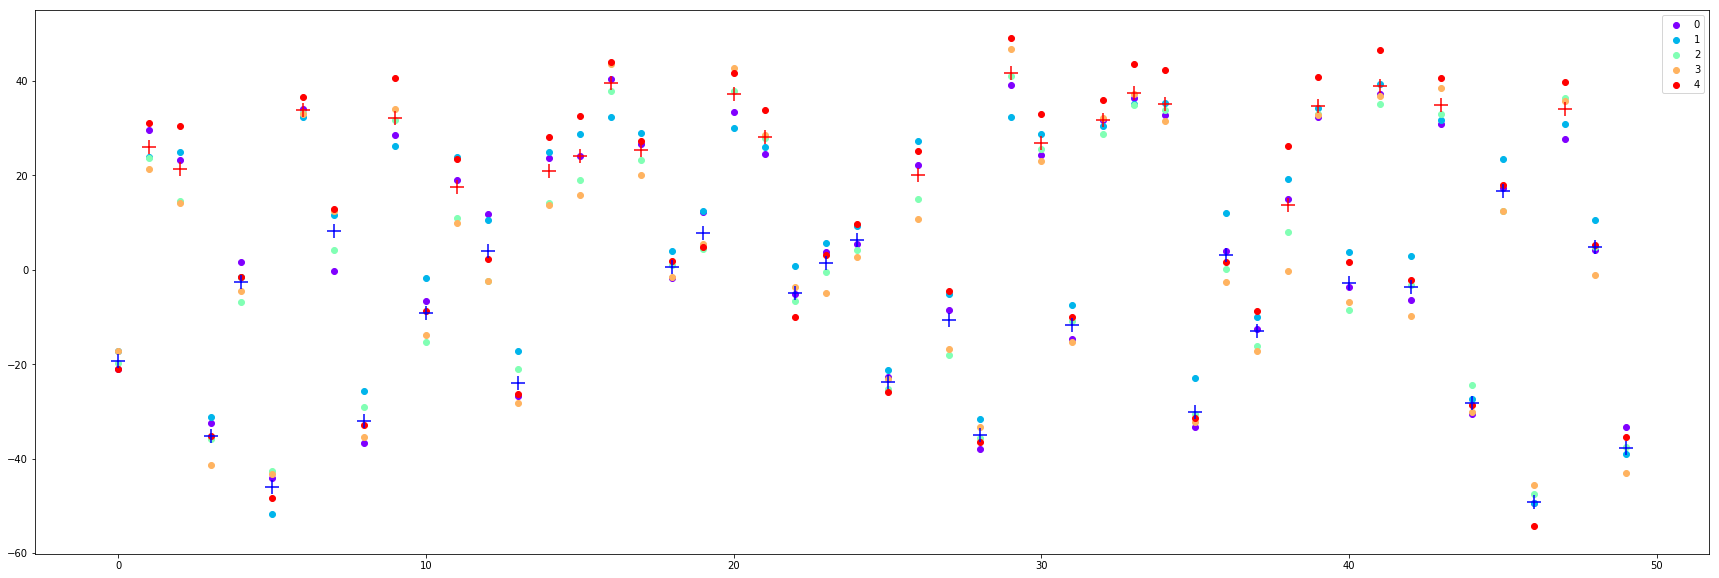

In [65]:
scores_subset = total_test_scores[0:5, 0:50]
labels_subset = test_labels[0:50]
plt.figure(figsize=(30, 10))
x = np.arange(scores_subset.shape[1])
ys = scores_subset
colors = cm.rainbow(np.linspace(0, 1, len(ys)))
s_set = []
for y, c in zip(ys, colors):
    s = plt.scatter(x, y, color=c)
    s_set.append(s)
plt.legend(s_set, range(len(s_set)))
y_mean = scores_subset.mean(0)
plt.scatter(x[labels_subset==1], y_mean[labels_subset==1], marker='+', s=200, color='r')
plt.scatter(x[labels_subset==0], y_mean[labels_subset==0], marker='+', s=200, color='b')

In [79]:
val_set = pd.read_pickle("trials/enr306/validation_set.pkl")
cohort_embeds = get_embeds(val_set.sample(n=1000).index, sv_embeds_full, id2idx)
enr_scores = compute_plda_score(total_enr_embeds, total_enr_embeds, plda_model_dir)
cohort_scores = compute_plda_score(total_enr_embeds, cohort_embeds, plda_model_dir)

In [80]:
margins = []
for i in range(len(total_enr_ids)):
    eer = compute_eer(enr_scores[i,:], cohort_scores[i, :])
    margin = enr_scores[i,:].mean() - cohort_scores[i,:].mean()
    print("{}: eer={:.4f}, margin={:.4f}".format(i, eer, margin))
    margins.append(margin)

0: eer=0.0000, margin=51.0146
1: eer=0.0000, margin=45.4580
2: eer=0.0000, margin=51.1740
3: eer=0.0000, margin=55.4491
4: eer=0.0000, margin=58.3115
5: eer=0.0000, margin=54.7377
6: eer=0.0000, margin=51.2945
7: eer=0.0000, margin=46.6152
8: eer=0.0000, margin=57.3144
9: eer=0.0000, margin=50.5848


In [81]:
margin_sorted = np.argsort(margins)

err=0.0342, eer=0.0100, fpr=0.0660, fnr=0.0020, thres=10.0000


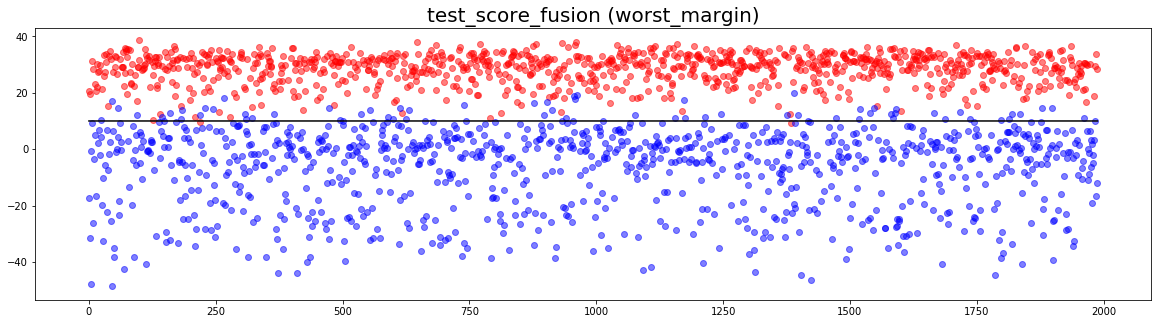

In [82]:
plot_score(total_test_scores[margin_sorted[:2]].mean(0), test_trial[1], vT, "test_score_fusion (worst_margin)")

err=0.0287, eer=0.0110, fpr=0.0540, fnr=0.0030, thres=10.0000


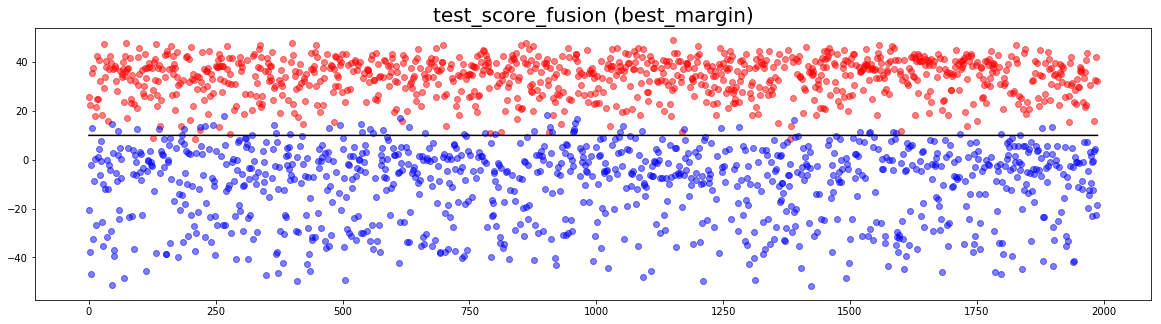

In [83]:
plot_score(total_test_scores[margin_sorted[-3:]].mean(0), test_trial[1], vT, "test_score_fusion (best_margin)")